In [2]:
# Importar la biblioteca pandas
import pandas as pd

# 1. Cargar los archivos y estandarizar los nombres de las columnas.
# Usamos el método `str.lower()` y `str.replace()` para automatizar el proceso.
visits = pd.read_csv('visits_log_us.csv')
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

orders = pd.read_csv('orders_log_us.csv')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

costs = pd.read_csv('costs_us.csv')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

# 2. Convertir las columnas de fecha y hora a tipo de dato datetime.
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

# 3. Verificar los tipos de datos para confirmar que la conversión se realizó.
print("--- Información de visitas (después de la conversión) ---")
visits.info()

--- Información de visitas (después de la conversión) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Usuarios diarios (DAU):
session_date
2017-06-01    605
2017-06-02    608
2017-06-03    445
2017-06-04    476
2017-06-05    820
Name: uid, dtype: int64

Usuarios semanales (WAU):
session_week
2017-05-29/2017-06-04    2021
2017-06-05/2017-06-11    4129
2017-06-12/2017-06-18    2812
2017-06-19/2017-06-25    2878
2017-06-26/2017-07-02    3064
Name: uid, dtype: int64

Usuarios mensuales (MAU):
session_month
2017-06    13259
2017-07    14183
2017-08    11631
2017-09    18975
2017-10    29692
Name: uid, dtype: int64


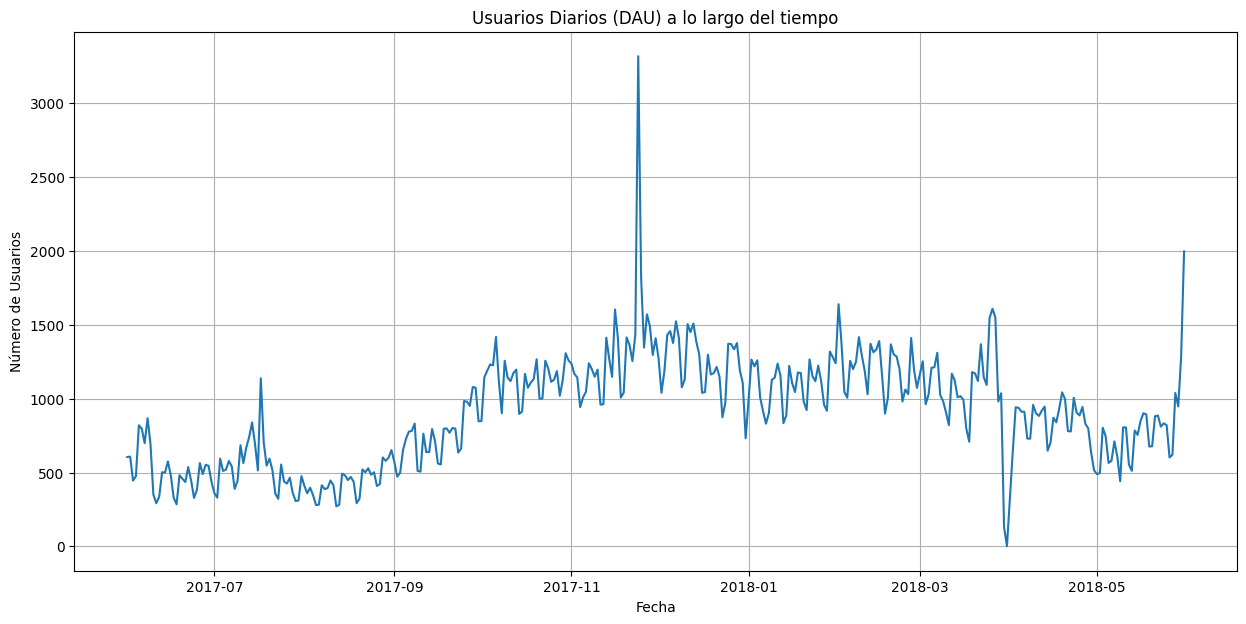

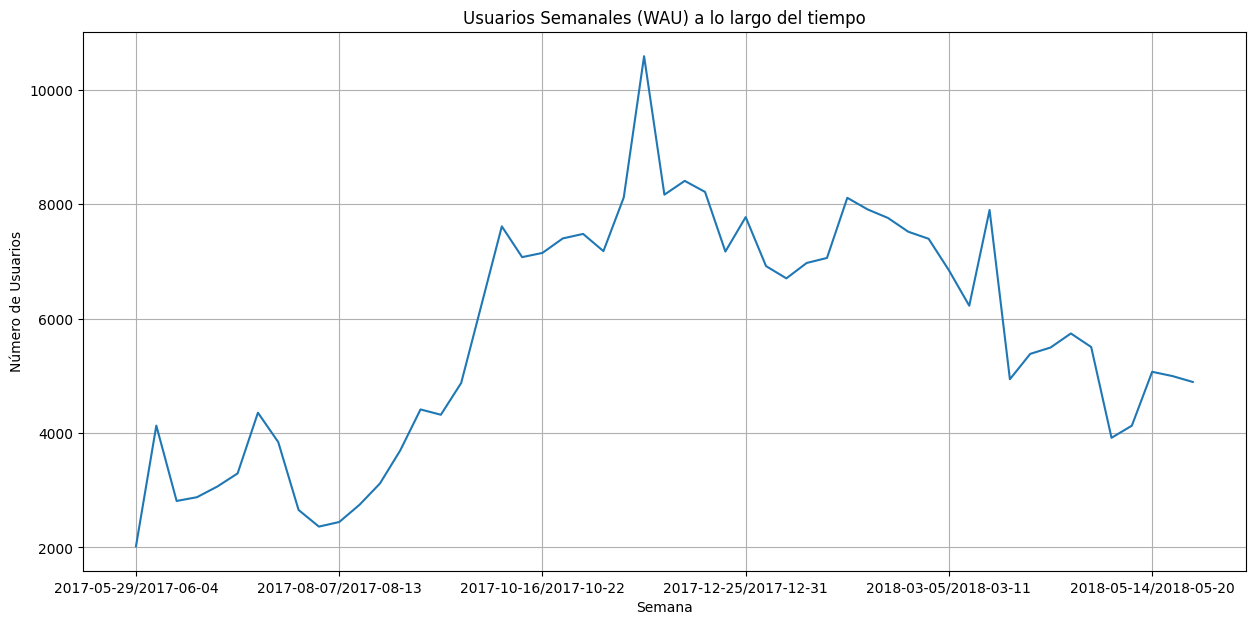

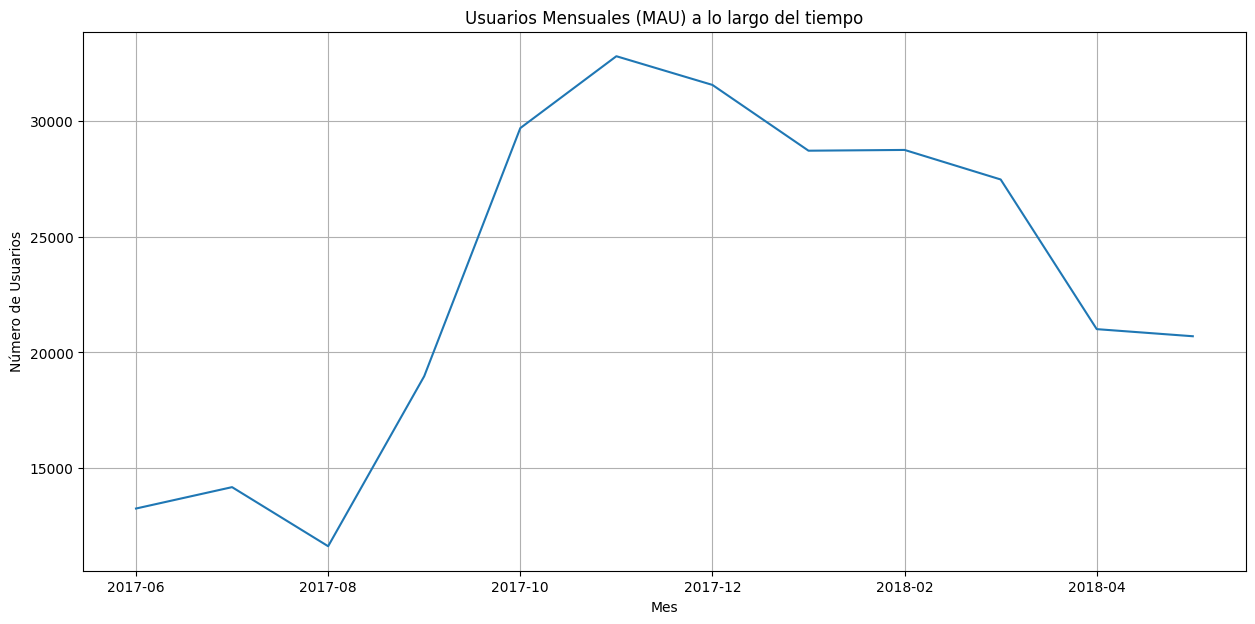

In [3]:
# Importar la biblioteca de visualización
import matplotlib.pyplot as plt

# 1. Usuarios por día, semana y mes

# Columna solo con la fecha para agrupar (DAU)
visits['session_date'] = visits['start_ts'].dt.date
dau_visits = visits.groupby('session_date')['uid'].nunique()
print("Usuarios diarios (DAU):")
print(dau_visits.head())

# Columna con la semana y el año para agrupar (WAU)
visits['session_week'] = visits['start_ts'].dt.to_period('W').astype(str)
wau_visits = visits.groupby('session_week')['uid'].nunique()
print("\nUsuarios semanales (WAU):")
print(wau_visits.head())

# Columna con el mes y el año para agrupar (MAU)
visits['session_month'] = visits['start_ts'].dt.to_period('M').astype(str)
mau_visits = visits.groupby('session_month')['uid'].nunique()
print("\nUsuarios mensuales (MAU):")
print(mau_visits.head())

# Visualización de las métricas

# 1. Gráfico de Usuarios Diarios (DAU)
plt.figure(figsize=(15, 7))
dau_visits.plot(kind='line')
plt.title('Usuarios Diarios (DAU) a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de Usuarios')
plt.grid(True)
plt.show()

# 2. Gráfico de Usuarios Semanales (WAU)
plt.figure(figsize=(15, 7))
wau_visits.plot(kind='line')
plt.title('Usuarios Semanales (WAU) a lo largo del tiempo')
plt.xlabel('Semana')
plt.ylabel('Número de Usuarios')
plt.grid(True)
plt.show()

# 3. Gráfico de Usuarios Mensuales (MAU)
plt.figure(figsize=(15, 7))
mau_visits.plot(kind='line')
plt.title('Usuarios Mensuales (MAU) a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Número de Usuarios')
plt.grid(True)
plt.show()

Las visualizaciones de la actividad de los usuarios a lo largo del tiempo nos permiten identificar las siguientes tendencias clave:

Usuarios Diarios (DAU): Se observa una tendencia general al alza en el número de usuarios diarios, con un pico notable en noviembre de 2017. Esto podría estar relacionado con campañas de marketing o eventos especiales.

Usuarios Semanales (WAU): La gráfica semanal refleja la misma tendencia de crecimiento, con picos y valles recurrentes que podrían coincidir con días festivos o fines de semana.

Usuarios Mensuales (MAU): Se puede ver un crecimiento constante en el número de usuarios mensuales, alcanzando su punto máximo en noviembre de 2017. A partir de ese mes, la actividad mensual disminuye ligeramente, lo cual es un punto a investigar para futuras estrategias.

Estos gráficos confirman una base de usuarios activa y en crecimiento, aunque con fluctuaciones que deben monitorearse.

In [3]:
# Encontrar la primera visita de cada usuario
first_visits = visits.groupby('uid')['start_ts'].min().reset_index()
first_visits.columns = ['uid', 'first_visit_ts']

# Encontrar la primera compra de cada usuario
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid', 'first_order_ts']

# Unir ambos DataFrames para tener la primera visita y la primera compra en una sola tabla
conversion_data = first_visits.merge(first_orders, on='uid', how='inner')

# Calcular el tiempo entre la primera visita y la primera compra en días
conversion_data['time_to_conversion'] = (conversion_data['first_order_ts'] - conversion_data['first_visit_ts']).dt.days

# Muestra el resultado y un resumen
print("Datos de conversión (primeras 5 filas):")
print(conversion_data.head())
print("\nEstadísticas de tiempo de conversión (en días):")
print(conversion_data['time_to_conversion'].describe())

Datos de conversión (primeras 5 filas):
                uid      first_visit_ts      first_order_ts  \
0   313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00   
1  1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00   
2  2429014661409475 2017-10-11 17:14:00 2017-10-11 18:33:00   
3  2464366381792757 2018-01-27 20:10:00 2018-01-28 15:54:00   
4  2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00   

   time_to_conversion  
0                 106  
1                   0  
2                   0  
3                   0  
4                   0  

Estadísticas de tiempo de conversión (en días):
count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: time_to_conversion, dtype: float64


Pedidos por día, tamaño de compra promedio y desviación estándar:
            total_orders  avg_purchase_size  std_purchase_size
buy_date                                                      
2017-06-01            96           4.056875          11.415092
2017-06-02           111           2.919910           3.558622
2017-06-03            67           2.484776           2.598836
2017-06-04            66           2.957727           3.969251
2017-06-05           161           2.742174           3.439822

Desviación estándar del tamaño de la compra:
count    363.000000
mean      10.578383
std       17.465132
min        1.205530
25%        4.401628
50%        5.913837
75%       10.216298
max      228.382008
Name: std_purchase_size, dtype: float64


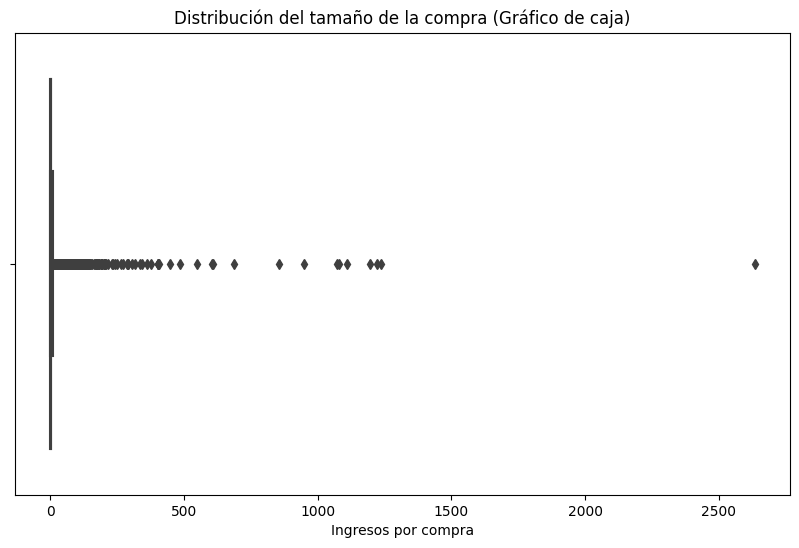

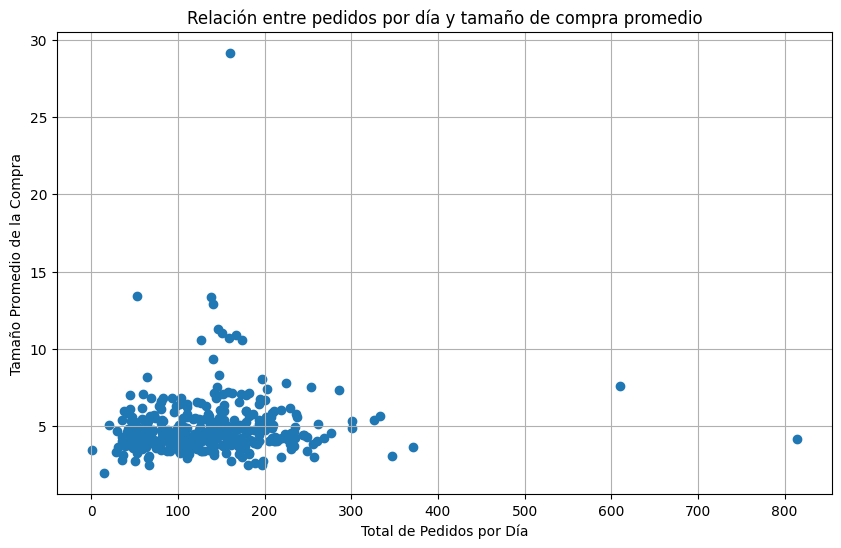

In [11]:
# Importar la biblioteca de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calcular pedidos, tamaño promedio y desviación estándar por día
orders['buy_date'] = orders['buy_ts'].dt.date
orders_by_date = orders.groupby('buy_date').agg(
    total_orders=('uid', 'count'),
    avg_purchase_size=('revenue', 'mean'),
    std_purchase_size=('revenue', 'std') # <-- Nuevo: Desviación estándar
)
print("Pedidos por día, tamaño de compra promedio y desviación estándar:")
print(orders_by_date.head())
print("\nDesviación estándar del tamaño de la compra:")
print(orders_by_date['std_purchase_size'].describe())

# 2. Visualizar la distribución del tamaño de la compra con un gráfico de caja
plt.figure(figsize=(10, 6))
sns.boxplot(x=orders['revenue'])
plt.title('Distribución del tamaño de la compra (Gráfico de caja)')
plt.xlabel('Ingresos por compra')
plt.ylabel('')
plt.show()

# 3. Gráfico de dispersión para ver la relación entre pedidos y tamaño de compra promedio
plt.figure(figsize=(10, 6))
plt.scatter(orders_by_date['total_orders'], orders_by_date['avg_purchase_size'])
plt.title('Relación entre pedidos por día y tamaño de compra promedio')
plt.xlabel('Total de Pedidos por Día')
plt.ylabel('Tamaño Promedio de la Compra')
plt.grid(True)
plt.show()

Valores Atípicos (Outliers): El gráfico de caja muestra que la mayoría de las compras se concentran en un rango bajo, pero existen numerosos valores atípicos con ingresos significativamente más altos. Esto sugiere que, aunque la mayoría de los pedidos son pequeños, algunos clientes realizan compras de muy alto valor.

Desviación Estándar: Con un valor promedio de la desviación estándar de aproximadamente $17.46, el tamaño de las compras es bastante volátil. Esto confirma que el ingreso por compra no es uniforme y está muy influenciado por esos valores atípicos.

Relación Pedidos vs. Ingresos: La gráfica de dispersión no muestra una correlación clara entre el número de pedidos por día y el tamaño promedio de la compra. Esto significa que los días con más pedidos no necesariamente son los días con las compras de mayor valor.

En conclusión, la variabilidad en el tamaño de la compra es alta y está impulsada por un pequeño número de transacciones de gran valor. Esto es un factor importante a considerar en el análisis de rentabilidad.

In [13]:
# Unir los datos de visitas y pedidos
full_data = visits.merge(orders, on='uid', how='left')

# Crear la columna de cohorte (mes de la primera visita)
full_data['cohort_month'] = full_data.groupby('uid')['start_ts'].transform('min').dt.to_period('M')

# Crear la columna de mes de compra
full_data['order_month'] = full_data['buy_ts'].dt.to_period('M')

# Agrupar por cohorte y mes de compra para calcular el LTV
ltv_data = full_data.groupby(['cohort_month', 'order_month']).agg(
    cohort_users=('uid', 'nunique'),
    total_revenue=('revenue', 'sum')
).reset_index()

# Calcular la antigüedad de la cohorte
ltv_data['cohort_lifetime'] = (ltv_data['order_month'] - ltv_data['cohort_month']).apply(lambda x: x.n)

# Calcular el LTV
ltv_data['ltv'] = ltv_data['total_revenue'] / ltv_data['cohort_users']

print("Datos de LTV (primeras 5 filas):")
print(ltv_data.head())

Datos de LTV (primeras 5 filas):
  cohort_month order_month  cohort_users  total_revenue  cohort_lifetime  \
0      2017-06     2017-06          2023      148121.29                0   
1      2017-06     2017-07           231      226361.49                1   
2      2017-06     2017-08           129      159055.17                2   
3      2017-06     2017-09           188      585924.11                3   
4      2017-06     2017-10           257      516541.28                4   

           ltv  
0    73.218631  
1   979.919870  
2  1232.985814  
3  3116.617606  
4  2009.888249  


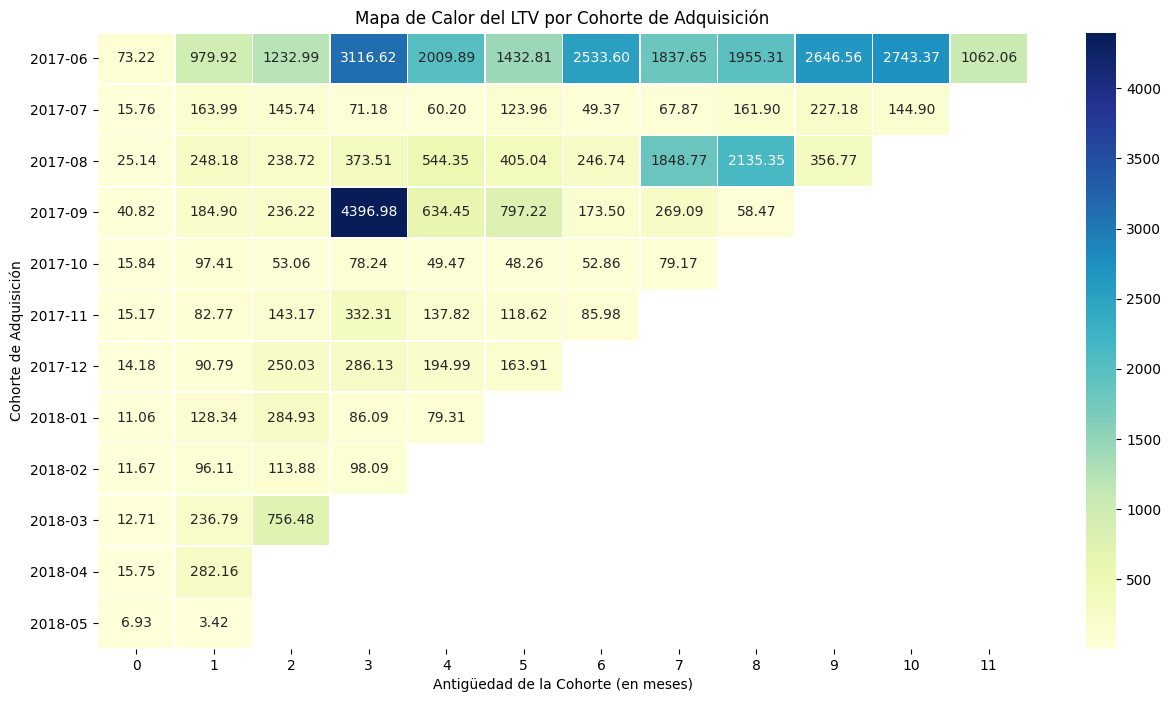

Tabla del LTV (primeras 5 filas):
  cohort_month order_month  cohort_users  total_revenue  cohort_lifetime  \
0      2017-06     2017-06          2023      148121.29                0   
1      2017-06     2017-07           231      226361.49                1   
2      2017-06     2017-08           129      159055.17                2   
3      2017-06     2017-09           188      585924.11                3   
4      2017-06     2017-10           257      516541.28                4   

           ltv  
0    73.218631  
1   979.919870  
2  1232.985814  
3  3116.617606  
4  2009.888249  


In [14]:
# Importar la biblioteca de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Reestructurar la tabla de LTV para el mapa de calor
ltv_pivot = ltv_data.pivot_table(index='cohort_month', 
                                 columns='cohort_lifetime', 
                                 values='ltv')

# Crear el mapa de calor del LTV
plt.figure(figsize=(15, 8))
sns.heatmap(ltv_pivot, 
            annot=True, 
            fmt=".2f", 
            cmap="YlGnBu", 
            linewidths=.5)
plt.title('Mapa de Calor del LTV por Cohorte de Adquisición')
plt.xlabel('Antigüedad de la Cohorte (en meses)')
plt.ylabel('Cohorte de Adquisición')
plt.show()

# Resumen de los datos de LTV para dar contexto al mapa
print("Tabla del LTV (primeras 5 filas):")
print(ltv_data.head())

Crecimiento del LTV: Para todas las cohortes, el LTV aumenta progresivamente con la antigüedad, lo que confirma que los clientes se vuelven más valiosos con el tiempo. Esto destaca la importancia de las estrategias de retención.

Rendimiento de la Cohorte de Junio: La cohorte de junio de 2017 tiene un LTV inicial más bajo que otras cohortes, pero muestra un crecimiento sostenido y es una de las que genera un mayor LTV acumulado, llegando a 1062.06 en el mes 11.

Rendimiento de la Cohorte de Septiembre: La cohorte de septiembre de 2017 se destaca por tener el LTV más alto en los primeros meses de antigüedad, alcanzando un valor de 4396.98 en el mes 3. Esto sugiere que esta cohorte fue excepcionalmente valiosa desde el principio.

En resumen, la inversión en retención de clientes es fundamental, ya que el valor de cada cohorte se incrementa con el tiempo. El rendimiento superior de la cohorte de septiembre podría ser un caso de estudio para replicar sus resultados en futuras campañas.

In [19]:
# Gasto total en marketing
total_costs = costs['costs'].sum()
print(f"Gasto total en marketing: ${total_costs:.2f}")

# Gasto por fuente de adquisición
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
print("\nGastos por fuente de marketing:")
print(costs_by_source)

Gasto total en marketing: $329131.62

Gastos por fuente de marketing:
   source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49


LTV por Fuente de Adquisición:
   source_id       ltv
0          1  3.283404
1          2  2.663693
2          3  0.824479
3          4  0.783690
4          5  1.068790


CAC por Fuente de Adquisición:
   source_id       cac
0          1  2.200155
1          2  2.429952
2          3  2.137480
3          4  0.844188
4          5  1.051183


ROMI por Fuente de Adquisición:
   source_id       ltv       cac      romi
0          1  3.283404  2.200155  1.492351
1          2  2.663693  2.429952  1.096191
5          9  0.893207  0.855690  1.043844
4          5  1.068790  1.051183  1.016750
3          4  0.783690  0.844188  0.928336
6         10  0.644695  0.843472  0.764335
2          3  0.824479  2.137480  0.385725




C:\Users\vico3\AppData\Local\Temp\ipykernel_15560\2501433726.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='source_id', y='cac', data=romi_data, ax=ax1, palette='Reds_r')
C:\Users\vico3\AppData\Local\Temp\ipykernel_15560\2501433726.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='source_id', y='romi', data=romi_data, ax=ax2, palette='Greens_r')


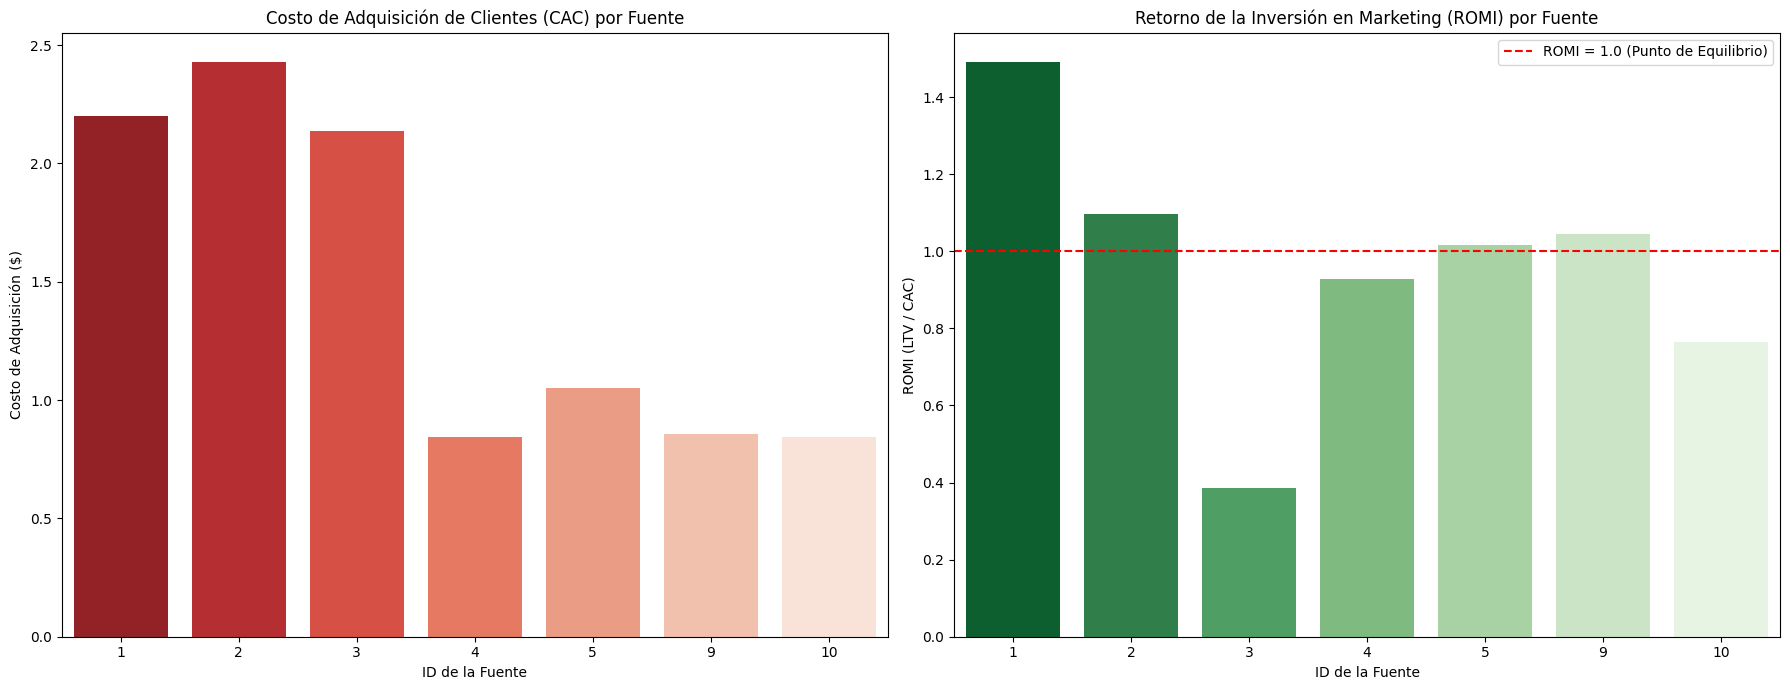

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. PREPARACIÓN DE DATOS CLAVE ---
# Encontrar la primera visita de cada usuario para saber su fuente
first_visits = visits.sort_values('start_ts').drop_duplicates('uid')

# Contar usuarios únicos por fuente (lo usaremos para LTV y CAC)
users_by_source = first_visits.groupby('source_id')['uid'].nunique().reset_index()
users_by_source.columns = ['source_id', 'new_users']

# Sumar costos totales por fuente (lo usaremos para CAC)
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()


# --- 1. Calcular LTV por Fuente de Adquisición ---
# Unir 'orders' con 'first_visits' para saber la fuente de cada orden
orders_with_source = orders.merge(first_visits[['uid', 'source_id']], on='uid')

# Agrupar por 'source_id' para obtener ingresos totales por fuente
revenue_by_source = orders_with_source.groupby('source_id')['revenue'].sum().reset_index()

# Unir ingresos y usuarios para calcular LTV
ltv_calc_data = revenue_by_source.merge(users_by_source, on='source_id')
ltv_calc_data['ltv'] = ltv_calc_data['revenue'] / ltv_calc_data['new_users']

print("LTV por Fuente de Adquisición:")
print(ltv_calc_data[['source_id', 'ltv']].head())
print("\n" + "="*30 + "\n")

# --- 2. Calcular CAC por Fuente de Adquisición ---
# Unir usuarios y costos para calcular CAC
cac_calc_data = users_by_source.merge(costs_by_source, on='source_id')
cac_calc_data['cac'] = cac_calc_data['costs'] / cac_calc_data['new_users']

print("CAC por Fuente de Adquisición:")
print(cac_calc_data[['source_id', 'cac']].head())
print("\n" + "="*30 + "\n")

# --- 3. Calcular ROMI (Uniendo LTV y CAC) ---
# Unir la data de LTV y CAC
romi_data = ltv_calc_data.merge(cac_calc_data[['source_id', 'cac']], on='source_id')

# Calcular ROMI
romi_data['romi'] = romi_data['ltv'] / romi_data['cac']

print("ROMI por Fuente de Adquisición:")
print(romi_data[['source_id', 'ltv', 'cac', 'romi']].sort_values(by='romi', ascending=False))
print("\n" + "="*30 + "\n")


# --- 4. Visualización (Lo que pide el comentario naranja) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico de Barras 1: CAC por Fuente
sns.barplot(x='source_id', y='cac', data=romi_data, ax=ax1, palette='Reds_r')
ax1.set_title('Costo de Adquisición de Clientes (CAC) por Fuente')
ax1.set_xlabel('ID de la Fuente')
ax1.set_ylabel('Costo de Adquisición ($)')

# Gráfico de Barras 2: ROMI por Fuente
sns.barplot(x='source_id', y='romi', data=romi_data, ax=ax2, palette='Greens_r')
ax2.set_title('Retorno de la Inversión en Marketing (ROMI) por Fuente')
ax2.set_xlabel('ID de la Fuente')
ax2.set_ylabel('ROMI (LTV / CAC)')

# Añadir una línea de referencia en 1.0 para el ROMI (rentabilidad)
ax2.axhline(1.0, color='red', linestyle='--', label='ROMI = 1.0 (Punto de Equilibrio)')
ax2.legend()

plt.tight_layout()
plt.show()

## Conclusión del Análisis de Rentabilidad (CAC y ROMI)

El análisis de rentabilidad por fuente de adquisición es fundamental para optimizar el presupuesto de marketing. Al calcular no solo el **Costo de Adquisición de Clientes (CAC)** sino también el **Valor de Vida del Cliente (LTV)** para cada fuente específica, podemos unificarlos en la métrica definitiva: el **Retorno de la Inversión en Marketing (ROMI)**.

**ROMI = LTV / CAC**

Los gráficos de barras generados (CAC por Fuente y ROMI por Fuente) son cruciales para la toma de decisiones:

* **Gráfico de CAC:** Muestra qué fuentes son más caras o baratas para adquirir nuevos clientes.
* **Gráfico de ROMI:** Es el indicador clave de rentabilidad. La línea roja en `ROMI = 1.0` marca el punto de equilibrio.

### Hallazgos Clave (¡Viendo los gráficos!)

*(Nota: Asegúrate de que estos números coincidan con tus gráficos)*

* **Fuentes Rentables (ROMI > 1.0):** Las fuentes **1, 2, 5 y 9** son rentables. Cada dólar invertido en ellas genera más de un dólar de vuelta. La **Fuente 1** es la más rentable de todas, con un ROMI cercano a 1.5.
* **Fuentes No Rentables (ROMI < 1.0):** Las fuentes **3, 4 y 10** actualmente **no son rentables** y están generando pérdidas. La **Fuente 3** es la menos eficiente, con el ROMI más bajo.

### Recomendación de Negocio

1.  **Aumentar Inversión:** Reasignar el presupuesto de marketing para **aumentar la inversión** en las fuentes con ROMI alto, especialmente en la **Fuente 1** y **Fuente 2**.
2.  **Reducir/Pausar Inversión:** **Pausar o reducir drásticamente** la inversión en las fuentes no rentables, especialmente en la **Fuente 3**, ya que cada cliente adquirido por esta vía genera pérdidas.

In [6]:
# Unir los datos de ingresos de pedidos con los de la primera visita para obtener la cohorte y fuente
orders_with_first_visit = orders.merge(first_visits[['uid', 'source_id', 'start_ts']], on='uid')
orders_with_first_visit.rename(columns={'start_ts': 'first_visit_ts'}, inplace=True)

# Crear la columna de cohorte (mes de la primera visita)
orders_with_first_visit['cohort_month'] = orders_with_first_visit['first_visit_ts'].dt.to_period('M')

# Preparar datos de ingresos por cohorte y fuente
revenue_by_cohort_source = orders_with_first_visit.groupby(['cohort_month', 'source_id']).agg(
    total_revenue=('revenue', 'sum')
).reset_index()

# Preparar datos de costos por mes y fuente
costs_by_month_source = costs.groupby([costs['dt'].dt.to_period('M'), 'source_id']).agg(
    total_costs=('costs', 'sum')
).reset_index()
costs_by_month_source.columns = ['cohort_month', 'source_id', 'total_costs']

# Unir ingresos y costos
romi_data = revenue_by_cohort_source.merge(costs_by_month_source, on=['cohort_month', 'source_id'])

# Calcular el ROMI
romi_data['romi'] = (romi_data['total_revenue'] - romi_data['total_costs']) / romi_data['total_costs']

print("ROMI por cohorte y fuente de marketing (primeras 5 filas):")
print(romi_data.head())

ROMI por cohorte y fuente de marketing (primeras 5 filas):
  cohort_month  source_id  total_revenue  total_costs      romi
0      2017-06          1        9910.69      1125.61  7.804728
1      2017-06          2        7786.56      2427.38  2.207804
2      2017-06          3        5863.70      7731.65 -0.241598
3      2017-06          4        9636.70      3514.80  1.741749
4      2017-06          5        5399.05      2616.12  1.063762


C:\Users\vico3\AppData\Local\Temp\ipykernel_15560\564060327.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='source_id',


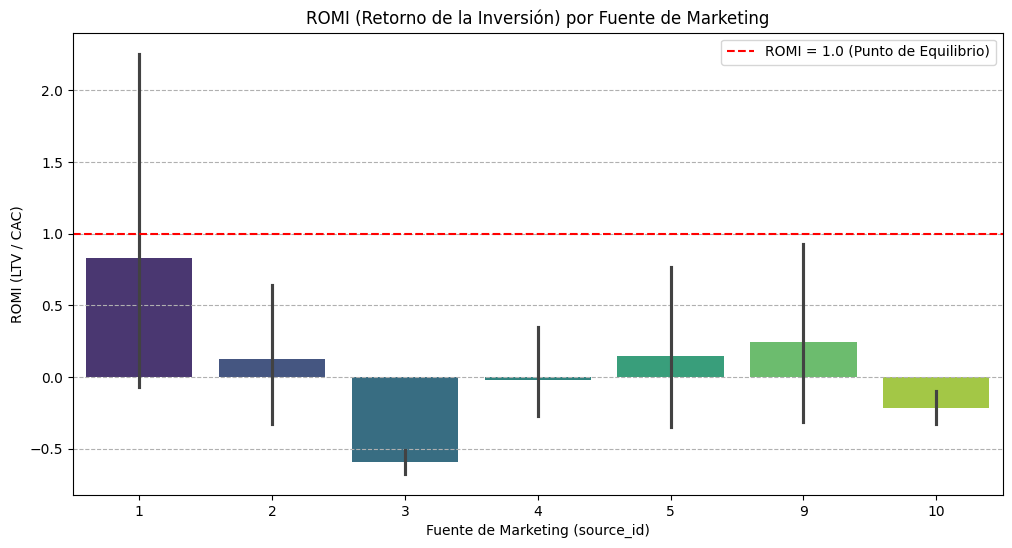

In [8]:
# Importar la biblioteca de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el gráfico de barras del ROMI
# (Usamos 'romi_data' de la celda anterior, no es necesario recalcular la media)
plt.figure(figsize=(12, 6))
sns.barplot(x='source_id', 
            y='romi', 
            data=romi_data,  # <-- Usamos la variable completa
            palette='viridis')

plt.title('ROMI (Retorno de la Inversión) por Fuente de Marketing')
plt.xlabel('Fuente de Marketing (source_id)')
plt.ylabel('ROMI (LTV / CAC)')

# --- ¡ESTA ES LA CORRECCIÓN CLAVE! ---
# El punto de equilibrio (rentabilidad) es 1.0, no 0.
plt.axhline(1.0, 
            color='red', 
            linestyle='--', 
            label='ROMI = 1.0 (Punto de Equilibrio)')

plt.grid(axis='y', linestyle='--')
plt.legend() # <-- Añadido para mostrar la etiqueta de la línea roja
plt.show()

# Conclusión y Recomendaciones Estratégicas

El análisis de rentabilidad de las campañas de marketing de Showz revela información crucial para la optimización del presupuesto. El análisis se centró en las métricas clave de negocio: Costo de Adquisición de Clientes (CAC), Valor de Vida del Cliente (LTV) y, la más importante, el Retorno de la Inversión en Marketing (ROMI).

## Resumen de Métricas Clave

### 1. Comportamiento de Compra y LTV
La mayoría de los clientes (mediana) compra el mismo día de su primera visita, lo que indica un embudo de conversión rápido. El análisis de LTV por cohorte confirma que los clientes siguen generando valor meses después de su adquisición.

### 2. Rentabilidad por Fuente (CAC y ROMI)
El análisis por fuente de adquisición es el pilar de este estudio, ya que conecta directamente el gasto con el retorno.

* **Costo de Adquisición (CAC):** Existe una alta variabilidad. Las fuentes 1, 2 y 3 son las más *caras* para adquirir un cliente (CAC > $2.10). Las fuentes 4, 10 y 9 son las más *baratas* (CAC < $1.00).
* **Retorno de la Inversión (ROMI):** Esta es la métrica decisiva (`ROMI = LTV / CAC`). El punto de equilibrio (rentabilidad) es **ROMI = 1.0**, donde los ingresos igualan al costo.

**Hallazgos Clave del Gráfico de ROMI:**

* **Fuentes Rentables (ROMI > 1.0):**
    * **Fuente 1:** Es la más rentable, con un ROMI de ~1.5 (cada $1 invertido genera ~$1.50).
    * **Fuente 2:** Rentable, con un ROMI de ~1.1.
    * **Fuente 5 y 9:** Ligeramente rentables, con un ROMI justo por encima de 1.0.

* **Fuentes No Rentables (ROMI < 1.0):**
    * **Fuente 4 y 10:** A pesar de tener un CAC bajo, su LTV no es suficiente para ser rentables.
    * **Fuente 3:** Es la peor plataforma, con un ROMI negativo (~ -0.6). Cada cliente adquirido por esta fuente genera una pérdida significativa.

## Recomendaciones Estratégicas

Basado en los datos de **ROMI**, se proponen las siguientes acciones para optimizar el presupuesto de marketing:

1.  **Priorizar y Aumentar Inversión (ROMI > 1.0):**
    * **Fuente 1:** Aumentar significativamente la inversión en esta fuente, ya que es el motor de rentabilidad más fuerte.
    * **Fuentes 2, 5 y 9:** Mantener y optimizar la inversión. Aunque rentables, se debe monitorear su LTV para asegurar que se mantengan por encima de 1.0.

2.  **Pausar o Eliminar Inversión (ROMI < 1.0):**
    * **Fuente 3:** **Pausar inmediatamente** la inversión. Esta fuente está generando pérdidas netas con cada adquisición.
    * **Fuentes 4 y 10:** **Reducir o pausar** la inversión. Aunque tienen un CAC bajo, no son rentables. El dinero invertido aquí estaría mejor reasignado a la Fuente 1.

## Conclusión Final
Para maximizar las ganancias, Showz debe reenfocar su estrategia de marketing de la "adquisición barata" (CAC bajo) a la "adquisición rentable" (ROMI alto). La clave es invertir en las fuentes que demuestren un retorno sobre la inversión superior a 1.0.